In [1]:
import os
import warnings
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import deepxde as dde
from deepxde.backend import tf

2024-12-04 22:07:57.200995: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term



Compiling model...
Building feed-forward neural network...
'build' took 0.035888 s

'compile' took 0.457705 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.85e-02, 1.37e-02, 4.67e-01]    [4.85e-02, 1.37e-02, 4.67e-01]    []  
1000      [3.80e-02, 9.93e-04, 5.40e-02]    [3.80e-02, 9.93e-04, 5.40e-02]    []  
2000      [3.00e-02, 1.14e-04, 4.14e-02]    [3.00e-02, 1.14e-04, 4.14e-02]    []  
3000      [9.56e-03, 7.70e-05, 8.96e-03]    [9.56e-03, 7.70e-05, 8.96e-03]    []  
4000      [5.20e-03, 2.36e-05, 4.32e-03]    [5.20e-03, 2.36e-05, 4.32e-03]    []  
5000      [3.66e-03, 1.37e-05, 3.11e-03]    [3.66e-03, 1.37e-05, 3.11e-03]    []  
6000      [3.12e-03, 8.52e-06, 2.53e-03]    [3.12e-03, 8.52e-06, 2.53e-03]    []  
7000      [2.11e-03, 5.52e-06, 2.13e-03]    [2.11e-03, 5.52e-06, 2.13e-03]    []  
8000      [1.06e-02, 3.39e-05, 2.01e-03]    [1.06e-02, 3.39e-05, 2.01e-03]    []  
9000      [1.72e-03, 6.59e-06, 1.

2024-12-04 22:18:58.060392: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_15/bias/Adam_3/Assign' id:22977 op device:{requested: '', assigned: ''} def:{{{node dense_15/bias/Adam_3/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_15/bias/Adam_3, dense_15/bias/Adam_3/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training model...

Step      Train loss                        Test loss                         Test metric
10017     [2.35e-03, 2.66e-06, 1.59e-03]    [1.29e-03, 2.66e-06, 1.59e-03]    []  
11000     [1.40e-03, 2.72e-06, 1.63e-03]    [1.33e-03, 2.72e-06, 1.63e-03]    []  
12000     [1.23e-03, 2.49e-06, 1.50e-03]    [1.19e-03, 2.49e-06, 1.50e-03]    []  
13000     [1.08e-03, 2.29e-06, 1.35e-03]    [1.05e-03, 2.29e-06, 1.35e-03]    []  
14000     [9.61e-04, 2.12e-06, 1.21e-03]    [9.40e-04, 2.12e-06, 1.21e-03]    []  
15000     [8.57e-04, 1.96e-06, 1.08e-03]    [8.41e-04, 1.96e-06, 1.08e-03]    []  
16000     [8.15e-04, 1.79e-06, 9.66e-04]    [8.10e-04, 1.79e-06, 9.66e-04]    []  
17000     [7.04e-04, 1.93e-06, 8.58e-04]    [6.91e-04, 1.93e-06, 8.58e-04]    []  
18000     [6.51e-04, 1.80e-06, 7.64e-04]    [6.44e-04, 1.80e-06, 7.64e-04]    []  
19000     [6.08e-04, 2.01e-06, 6.78e-04]    [6.01e-04, 2.01e-06, 6.78e-04]    []  
20000     [2.42e-03, 5.33e-06, 5.88e-04]    [2.39e-03, 5.33e-

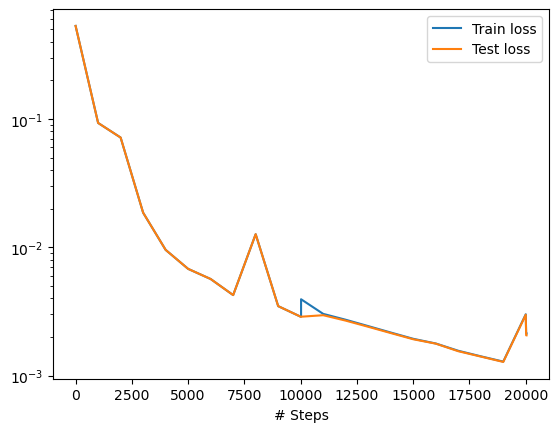

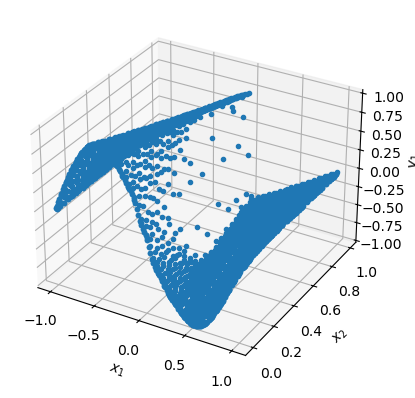

L2 relative error: 0.09051549431206905


In [ ]:
def gen_testdata():
    data = np.load("Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y


def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial
)

data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=2500, num_boundary=100, num_initial=160
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1.0e-3)
model.train(iterations=10000)
model.compile("L-BFGS")
model.train()

X = geomtime.random_points(100000)
err = 1
f = model.predict(X, operator=pde)
err_eq = np.absolute(f)
err = np.mean(err_eq)
print("Mean residual: %.3e" % (err))

x_id = np.argmax(err_eq)
print("Adding new point:", X[x_id], "\n")
data.add_anchors(X[x_id])
early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
model.compile("adam", lr=1e-3)
model.train(iterations=10000, disregard_previous_best=True, callbacks=[early_stopping], model_save_path='model')
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

X, y_true = gen_testdata()
y_pred = model.predict(X)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))